In [15]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df = pd.read_csv('data/BostonHousing.csv')

In [17]:
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


### Lets remove outliers

In [18]:
df = df[~(df['medv'] >= 50.0)]
print(np.shape(df))

(490, 14)


<Axes: >

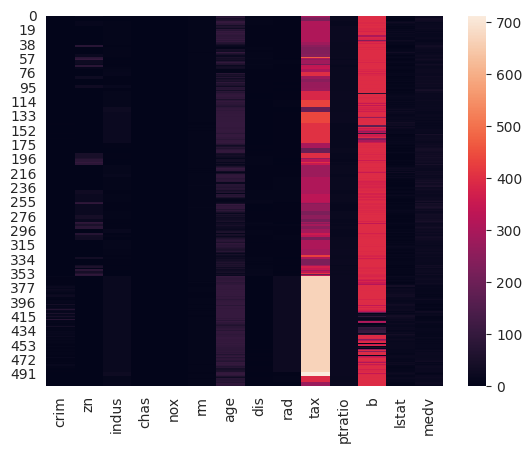

In [19]:
sns.heatmap(df)

<Axes: >

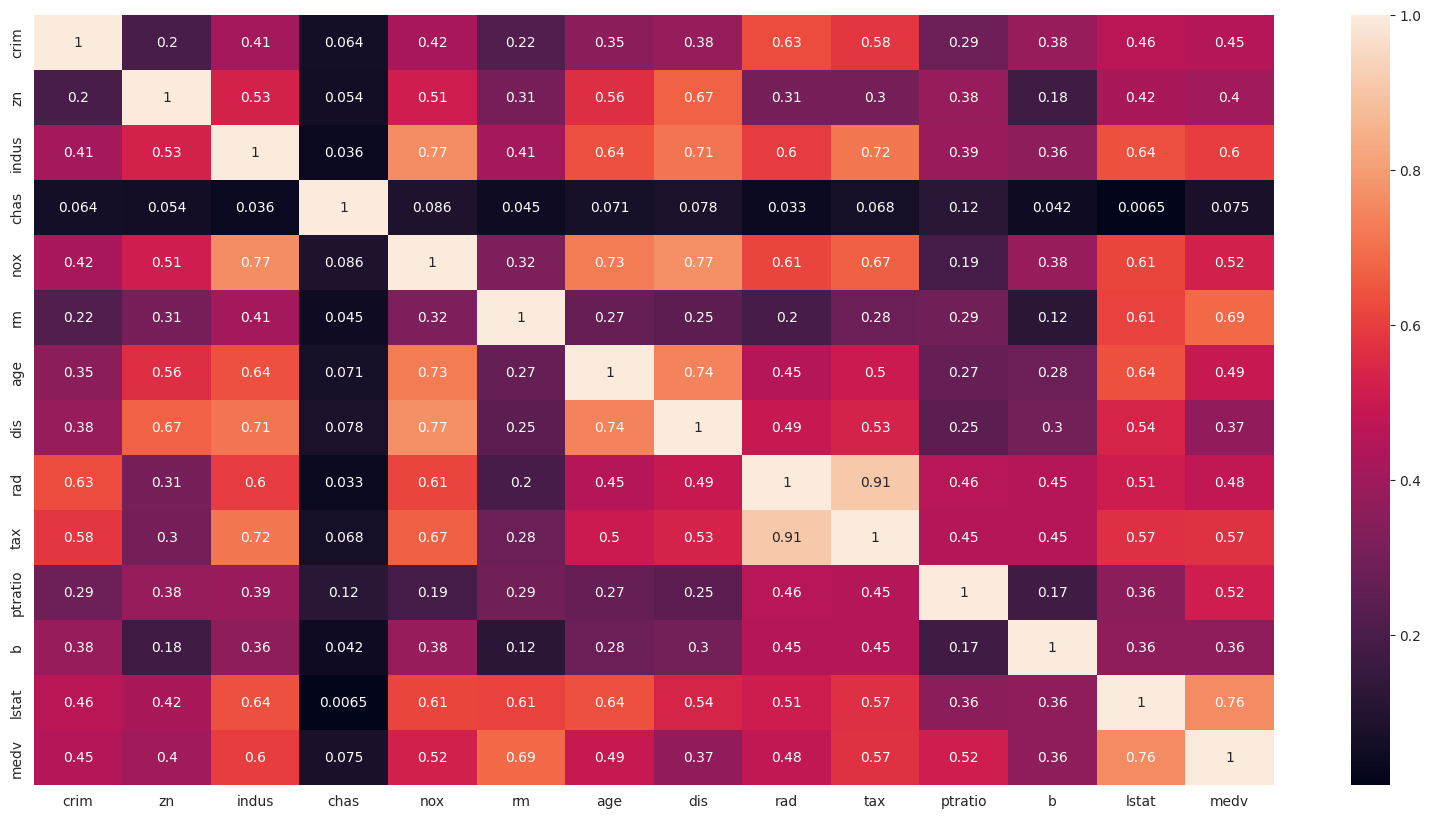

In [20]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(),  annot=True)

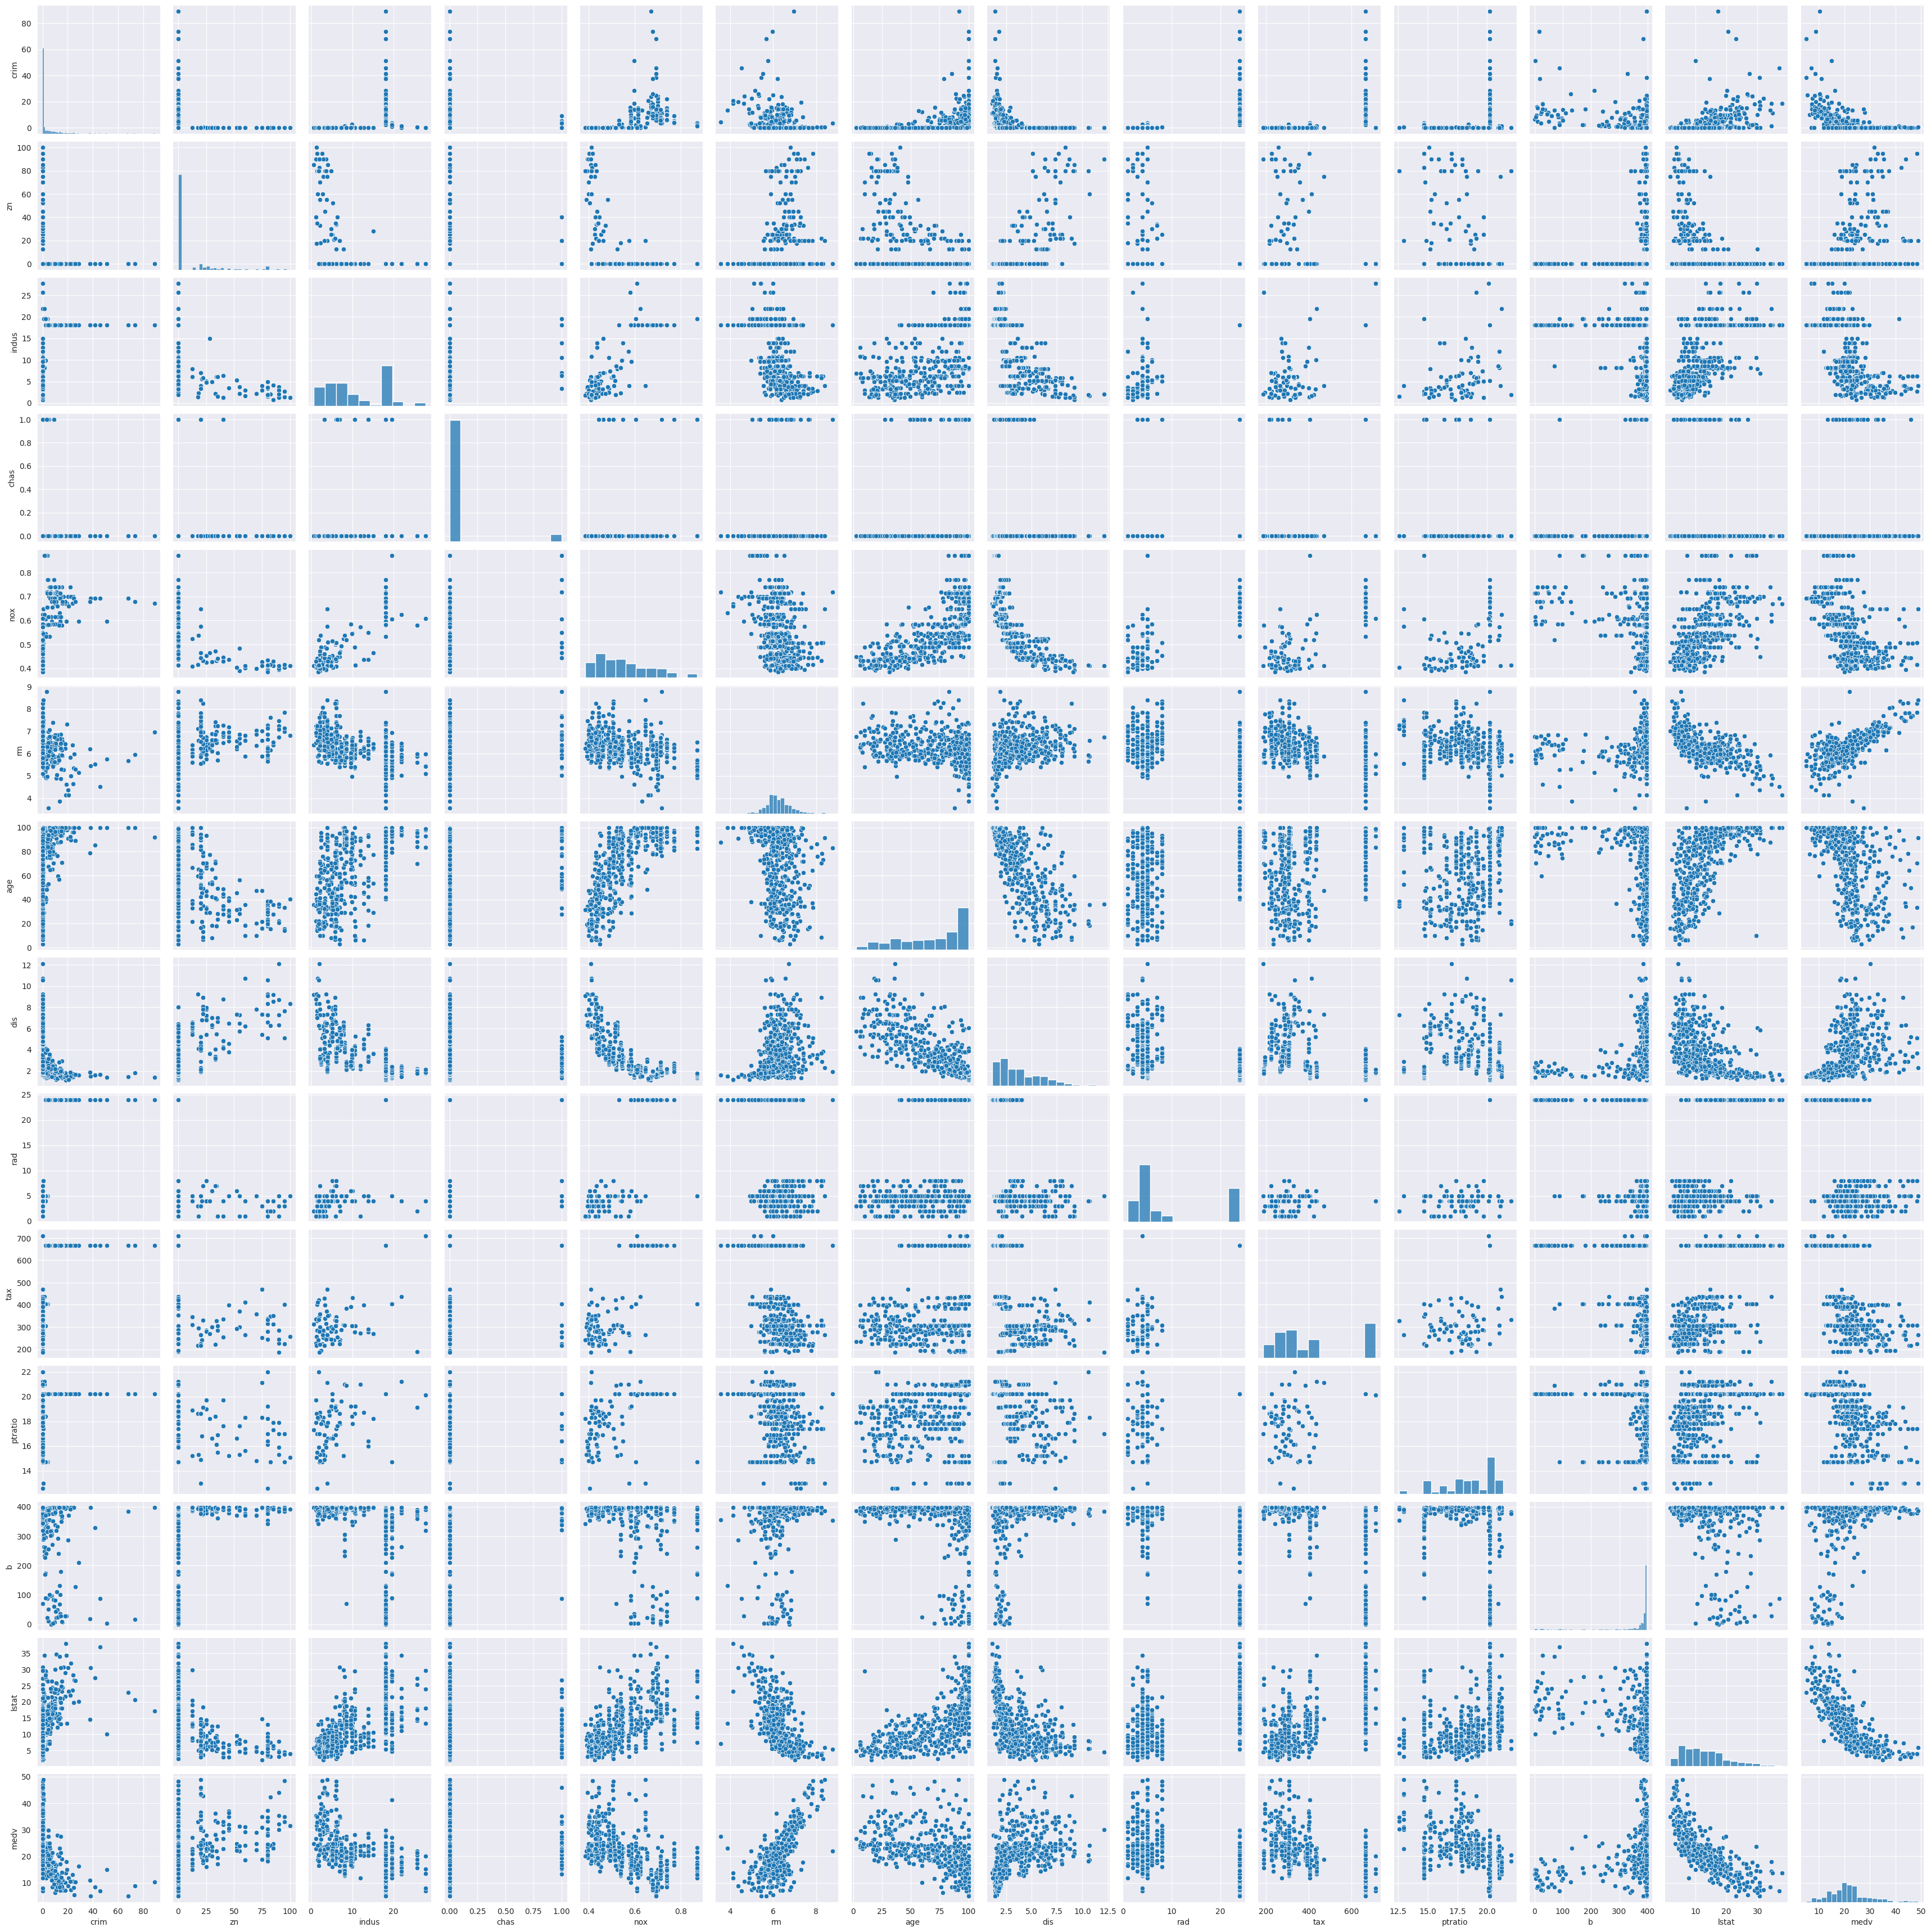

In [21]:
sns.pairplot(df)

In [22]:
corrd = df.corr()

In [23]:
def getCorrelatedFeature(Corrdata, threshold):
    feature = []
    value = []
    
    for i , index in enumerate(Corrdata.index):
        if abs(Corrdata[index])>threshold:
            feature.append(index)
            print(index)
            value.append(Corrdata[index])
    df = pd.DataFrame(data = value, index = feature, columns = ['corr value'])
    return df

In [24]:
threshold = 0.4
corr_value = getCorrelatedFeature(corrd['medv'],threshold)

crim
zn
indus
nox
rm
age
rad
tax
ptratio
lstat
medv


### splitting dataset

From correlation matrix, we see TAX and RAD are highly correlated features. The columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above 0.5 with MEDV which is a good indication of using as predictors. Let's plot these columns against MEDV.

In [26]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
column_sels = ['lstat', 'indus', 'nox', 'ptratio', 'rm', 'tax', 'dis', 'age']


x = df.loc[:,column_sels]
y = df['medv']


x = pd.DataFrame(data=scaler.fit_transform(x), columns=column_sels)


In [34]:
# X = CD.drop(labels = ['medv'], axis = 1)
# y = CD['medv']

In [30]:
y =  np.log1p(y)
for col in x.columns:
    if np.abs(x[col].skew()) > 0.3:
        x[col] = np.log1p(x[col])

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test , y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0 )

In [35]:
from sklearn import datasets
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Lets try polinomial regression with L2 with degree for the best fit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


model1 = LinearRegression()
model2 = KFold(n_splits=10)
model3 = SVR(kernel='rbf', C=1e3, gamma=0.1)
model4 = DecisionTreeRegressor(max_depth=5)
model4 = KNeighborsRegressor(n_neighbors=7)
model5 = GradientBoostingRegressor(alpha=0.9,learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)

scaler = MinMaxScaler()

x_scaled = scaler.fit_transform(x)


In [36]:
scores = cross_val_score(model1, 
                         x_scaled, 
                         y, 
                         cv=model2, 
                         scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

scores_map = {}
scores_map['LinearRegression'] = scores

model1 = Ridge()
scores = cross_val_score(model1, 
                         x_scaled, 
                         y, 
                         cv=model2, 
                         scoring='neg_mean_squared_error')
scores_map['Ridge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


model = make_pipeline(PolynomialFeatures(degree=3), 
                      Ridge())
scores = cross_val_score(model, 
                         x_scaled, 
                         y, 
                         cv=model2, 
                         scoring='neg_mean_squared_error')
scores_map['PolyRidge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

scores = cross_val_score(model3, 
                         x_scaled, 
                         y, 
                         cv=model2, 
                         scoring='neg_mean_squared_error')
scores_map['SVR'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


scores = cross_val_score(model4, 
                         x_scaled, 
                         y, 
                         cv=model2, 
                         scoring='neg_mean_squared_error')
scores_map['DecisionTreeRegressor'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


scores = cross_val_score(model4, 
                         x_scaled, 
                         y, 
                         cv=model2, 
                         scoring='neg_mean_squared_error')
scores_map['KNeighborsRegressor'] = scores
print("model4 Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))



scores = cross_val_score(model5, 
                         x_scaled, 
                         y, 
                         cv=model2, 
                         scoring='neg_mean_squared_error')
scores_map['GradientBoostingRegressor'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.00 (+/- 0.00)
MSE: -0.00 (+/- 0.00)
MSE: -0.00 (+/- 0.00)
MSE: -0.01 (+/- 0.00)
MSE: -0.00 (+/- 0.00)
model4 Accuracy: -0.00 (+/- 0.00)
MSE: -0.00 (+/- 0.00)


/tmp/ipykernel_41526/4263796664.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row_data])], ignore_index=True)


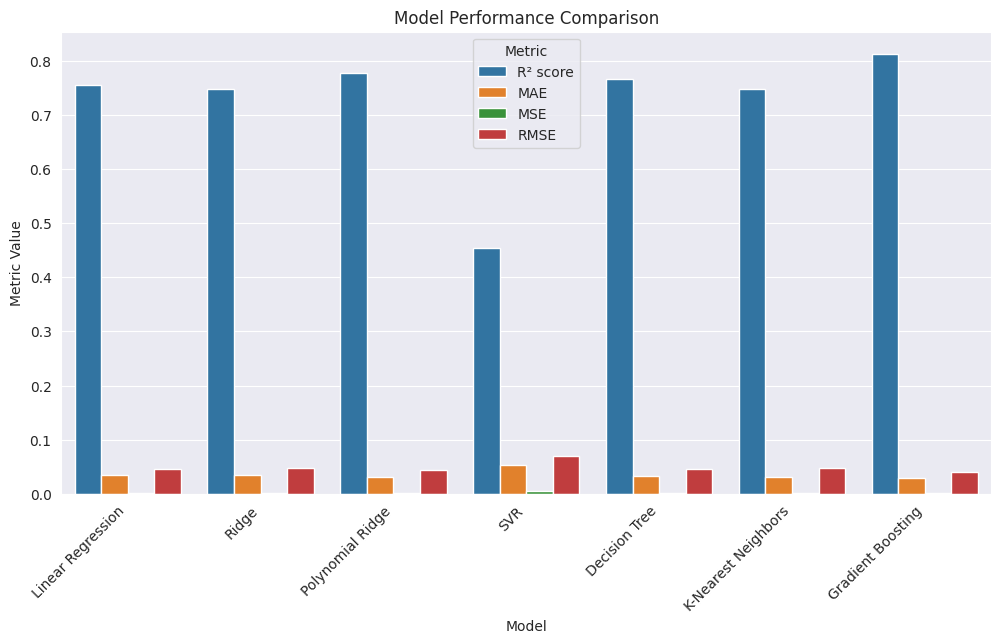

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create a dictionary to store the models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Polynomial Ridge": make_pipeline(PolynomialFeatures(degree=3), Ridge()),
    "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1),
    "Decision Tree": DecisionTreeRegressor(max_depth=5),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=7),
    "Gradient Boosting": GradientBoostingRegressor(alpha=0.9, learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)
}
# Create a DataFrame to store the metrics for each model
metrics_df = pd.DataFrame(columns=["Model", "R² score", "MAE", "MSE", "RMSE"])

# Fit each model and calculate performance metrics
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)

    # Create a new row (dictionary) for the current model's metrics
    new_row_data = {
        "Model": name,
        "R² score": r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    }

    # Append the new row data to metrics_df using pd.concat
    metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row_data])], ignore_index=True)

# Melt the DataFrame for easier plotting
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# Create the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Model", y="Value", hue="Metric", data=metrics_melted)
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.legend(title="Metric")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()

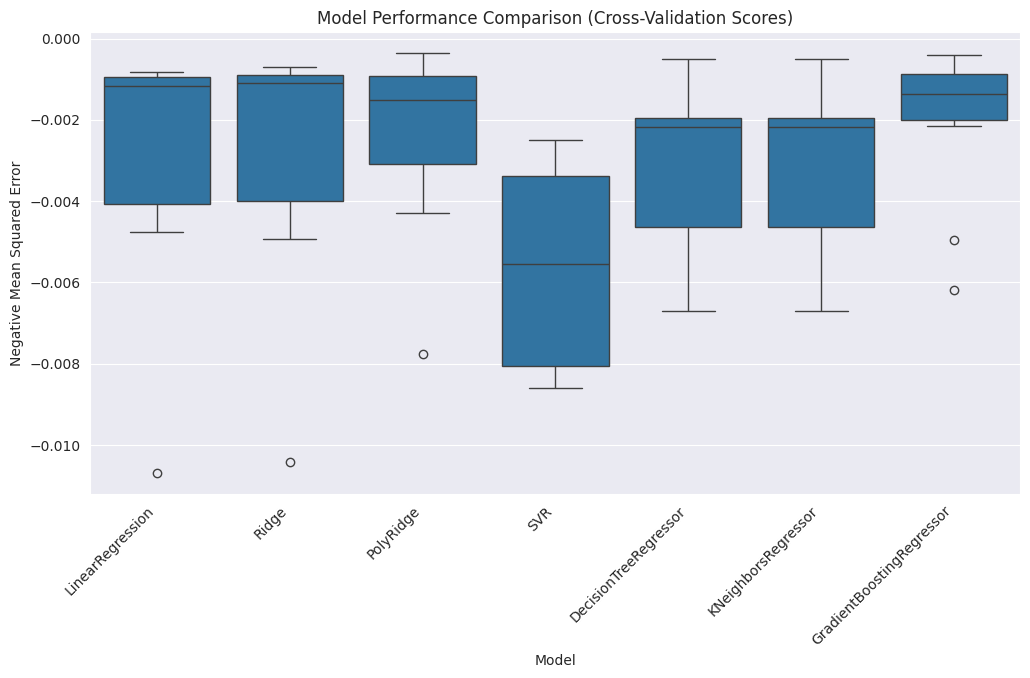

In [38]:
# Create a DataFrame to store the scores for each model
scores_df = pd.DataFrame(scores_map)

# Melt the DataFrame for easier plotting
scores_melted = scores_df.melt(var_name="Model", value_name="Score")

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Model", y="Score", data=scores_melted)
plt.title("Model Performance Comparison (Cross-Validation Scores)")
plt.xlabel("Model")
plt.ylabel("Negative Mean Squared Error")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()

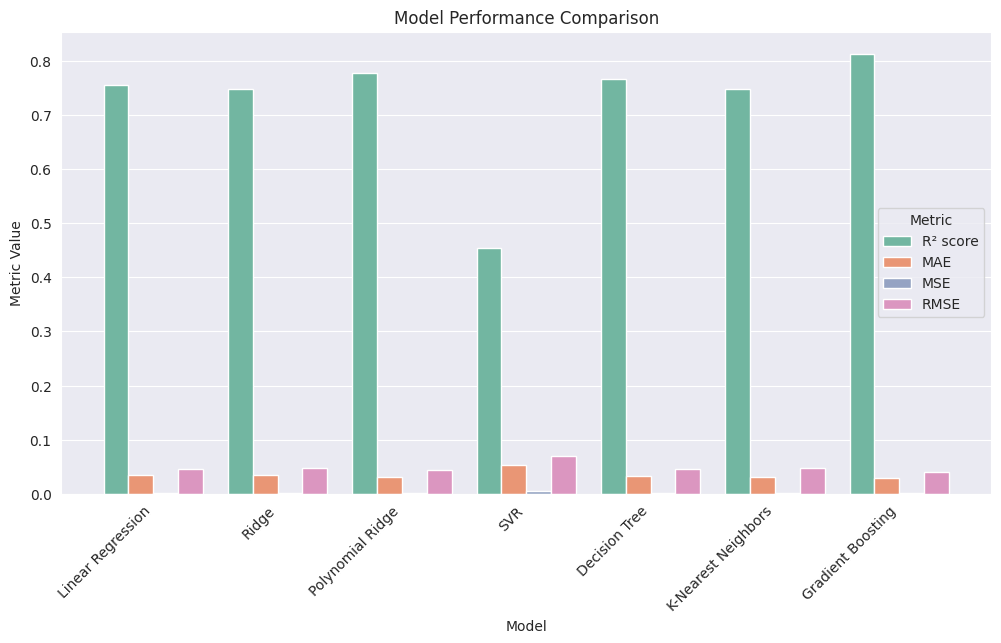

In [39]:
# Melt the DataFrame for easier plotting
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# Create the bar plot with different colors
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Model", y="Value", hue="Metric", data=metrics_melted, palette="Set2")
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.legend(title="Metric")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

# Add lines to show interconnections
for i, model in enumerate(metrics_df["Model"].unique()):
    model_data = metrics_melted[metrics_melted["Model"] == model]
    for metric in model_data["Metric"].unique():
        metric_data = model_data[model_data["Metric"] == metric]
        ax.plot([i, i], [metric_data["Value"].min(), metric_data["Value"].max()], color='black', linestyle='--')

plt.show()

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Convert the target variable to binary classification
# For simplicity, let's classify MEDV as 1 if it's above the median value, otherwise 0
median_value = y.median()
y_binary = (y > median_value).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.3, random_state=0)

# Initialize and train the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[64 16]
 [16 56]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        80
           1       0.78      0.78      0.78        72

    accuracy                           0.79       152
   macro avg       0.79      0.79      0.79       152
weighted avg       0.79      0.79      0.79       152



In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Create a dictionary to store the classification models
classification_models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Create a dictionary to store the classification reports for each model
classification_reports = {}

# Iterate through each model, make predictions, and generate the classification report
for name, model in classification_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports[name] = report

# Convert the classification reports dictionary to a DataFrame for better visualization
classification_reports_df = pd.DataFrame(classification_reports).transpose()

# Display the classification reports DataFrame
classification_reports_df

,0,1,accuracy,macro avg,weighted avg
Logistic Regression,"{'precision': 0.8, 'recall': 0.8, 'f1-score': ...","{'precision': 0.7777777777777778, 'recall': 0....",0.789474,"{'precision': 0.788888888888889, 'recall': 0.7...","{'precision': 0.7894736842105263, 'recall': 0...."
Decision Tree,"{'precision': 0.8157894736842105, 'recall': 0....","{'precision': 0.7631578947368421, 'recall': 0....",0.789474,"{'precision': 0.7894736842105263, 'recall': 0....","{'precision': 0.7908587257617729, 'recall': 0...."
Random Forest,"{'precision': 0.813953488372093, 'recall': 0.8...","{'precision': 0.8484848484848485, 'recall': 0....",0.828947,"{'precision': 0.8312191684284708, 'recall': 0....","{'precision': 0.8303104484255035, 'recall': 0...."
SVM,"{'precision': 0.825, 'recall': 0.825, 'f1-scor...","{'precision': 0.8055555555555556, 'recall': 0....",0.815789,"{'precision': 0.8152777777777778, 'recall': 0....","{'precision': 0.8157894736842105, 'recall': 0...."
K-Nearest Neighbors,"{'precision': 0.8076923076923077, 'recall': 0....","{'precision': 0.7702702702702703, 'recall': 0....",0.789474,"{'precision': 0.788981288981289, 'recall': 0.7...","{'precision': 0.7899660794397636, 'recall': 0...."
